In [1]:
import os, argparse
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pytz import timezone
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.backends.cudnn as cudnn
import torchvision
import wandb

import datasets
# from utils import select_device, natural_keys, gazeto3d, angular, getArch
from utils import select_device, natural_keys, gazeto3d, angular, getArch
from model import L2CS

In [2]:
# check if we have the correct number of checkpoint files 
ppath ='/project/results/output/snapshots/' 
for fold in range(15):
    foldstr = f"fold{fold:0>2}"
    cpath =os.path.join(ppath, foldstr)
    files = os.listdir(cpath)
    print(len(files), end=" ")

61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 

In [3]:
def parse_args():
    """Parse input arguments."""
    parser = argparse.ArgumentParser(
        description='Gaze estimation using L2CSNet .')
     # Gaze360
    parser.add_argument(
        '--gaze360image_dir', dest='gaze360image_dir', help='Directory path for gaze images.',
        default='datasets/Gaze360/Image', type=str)
    parser.add_argument(
        '--gaze360label_dir', dest='gaze360label_dir', help='Directory path for gaze labels.',
        default='datasets/Gaze360/Label/test.label', type=str)
    # mpiigaze
    parser.add_argument(
        '--gazeMpiimage_dir', dest='gazeMpiimage_dir', help='Directory path for gaze images.',
        default='datasets/MPIIFaceGaze/Image', type=str)
    parser.add_argument(
        '--gazeMpiilabel_dir', dest='gazeMpiilabel_dir', help='Directory path for gaze labels.',
        default='datasets/MPIIFaceGaze/Label', type=str)
    # Important args -------------------------------------------------------------------------------------------------------
    # ----------------------------------------------------------------------------------------------------------------------
    parser.add_argument(
        '--dataset', dest='dataset', help='gaze360, mpiigaze',
        default= "gaze360", type=str)
    parser.add_argument(
        '--snapshot', dest='snapshot', help='Path to the folder contains models.', 
        default='output/snapshots/L2CS-gaze360-_loader-180-4-lr', type=str)
    parser.add_argument(
        '--evalpath', dest='evalpath', help='path for the output evaluating gaze test.',
        default="evaluation/L2CS-gaze360-_loader-180-4-lr", type=str)
    parser.add_argument(
        '--gpu',dest='gpu_id', help='GPU device id to use [0]',
        default="0", type=str)
    parser.add_argument(
        '--batch_size', dest='batch_size', help='Batch size.',
        default=100, type=int)
    parser.add_argument(
        '--arch', dest='arch', help='Network architecture, can be: ResNet18, ResNet34, [ResNet50], ''ResNet101, ResNet152, Squeezenet_1_0, Squeezenet_1_1, MobileNetV2',
        default='ResNet50', type=str)
    # ---------------------------------------------------------------------------------------------------------------------
    # Important args ------------------------------------------------------------------------------------------------------
    args = parser.parse_args()
    return args

In [4]:
class Nothing:
    pass
args = Nothing()
args.gazeMpiimage_dir = '/project/data/Image'  # syn data 
args.gazeMpiilabel_dir = '/project/data/Label'  # syn label
args.output = '/project/results/soutput/snapshots/'  # real model
args.dataset = 'mpiigaze'
args.snapshot='/project/results/soutput/snapshots/'  # real data model
args.evalpath = '/project/results/rsoutput/evaluation/'
args.gpu_id = '0,1,2,3'
args.gpu_id = '0'
args.batch_size = 20
args.arch = 'ResNet50'
args.bins=28
args.angle = 180
args.bin_width = 4


In [5]:
batch_size=args.batch_size
arch=args.arch
data_set=args.dataset
evalpath =args.evalpath
snapshot_path = args.snapshot
bins=args.bins
angle=args.angle
bin_width=args.bin_width

In [6]:
!ls ../results

README	daoutput  output  rsoutput  soutput  sroutput


In [7]:
# args = parse_args()
cudnn.enabled = True
gpu = select_device(args.gpu_id, batch_size=args.batch_size)
transformations = transforms.Compose([
    transforms.Resize(448),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

model_used=getArch(arch, bins)  #resnet50 and 28 bins

In [8]:
# fold=2
# folder = os.listdir(os.path.join(snapshot_path, "fold" + f'{fold:0>2}'))
# folder.sort(key=natural_keys)
# folder.pop(-1)  #remove the tensorboard file
# # print(folder)
# epochs = folder[3]
# os.path.join(snapshot_path+"fold"+f'{fold:0>2}', epochs)

In [9]:
# print(evalpath, snapshot_path)

In [10]:
# print(data_set)

In [11]:
%%time

ims_errs = {}

for fold in range(15):
    print(f"fold={fold}")
    
    now = datetime.utcnow()
    now = now.astimezone(timezone('US/Pacific'))
    date_format='%m/%d/%Y %H:%M:%S'
    now = now.strftime(date_format)
    
    print(args.gazeMpiilabel_dir)
    folder = os.listdir(args.gazeMpiilabel_dir)
    folder.sort()  #individual label files
    testlabelpathcombined = [os.path.join(args.gazeMpiilabel_dir, j) for j in folder] 
#     print(testlabelpathcombined)
#     print(args.gazeMpiimage_dir)
    gaze_dataset=datasets.Mpiigaze(testlabelpathcombined, args.gazeMpiimage_dir, transformations, False, angle, fold)

    test_loader = torch.utils.data.DataLoader(
        dataset=gaze_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True)

    fold_path = os.path.join(evalpath, 'fold' + f'{fold:0>2}'+'/')  #for evaluation
#     print(f"fold_path is {fold_path}")
#     if not os.path.exists(fold_path):
#         os.makedirs(fold_path)

#     if not os.path.exists(os.path.join(evalpath, f"fold"+str(fold))):
#         os.makedirs(os.path.join(evalpath, f"fold"+str(fold)))

    # list all epochs for testing
    folder = os.listdir(os.path.join(snapshot_path, "fold" + f'{fold:0>2}'))
    folder.sort(key=natural_keys)
    folder.pop(-1)  #remove the tensorboard file, now all snapshot files
#     print(f"folder={folder}")  #contains all the checkpoint files
                    

    softmax = nn.Softmax(dim=1)
#     with open(os.path.join(evalpath, os.path.join("fold"+f'{fold:0>2}', data_set+".log")), 'w') as outfile:
        
    configuration = (f"\ntest configuration equal gpu_id={gpu}, batch_size={batch_size}, model_arch={arch}\n"
                     f"Start testing dataset={data_set}, FOLD={fold} --{now}---------")
    print(configuration)

#     outfile.write(configuration)
    epoch_list=[]
    avg_MAE=[]
    for epochs in folder: 
        x = ''.join(filter(lambda i: i.isdigit(), epochs))
        x = int(x)
        if x != 39:
            continue
#         print(f"epochs={epochs}")
        model=model_used
        checkpoint = torch.load(os.path.join(snapshot_path+"fold"+f'{fold:0>2}', epochs))
#         print(f"checkpoint={checkpoint}")
        saved_state_dict = checkpoint['model_state_dict']
        model= nn.DataParallel(model,device_ids=[0])
        model.load_state_dict(saved_state_dict)
        model.cuda(gpu)
        model.eval()
        total = 0
        idx_tensor = [idx for idx in range(28)]
        idx_tensor = torch.FloatTensor(idx_tensor).cuda(gpu)
        avg_error = .0
        
        print(f"epochs={epochs}")
        
        with torch.no_grad():
            for j, (images, labels, cont_labels, name) in enumerate(test_loader):
#                 print(f"name={name}")
                images = Variable(images).cuda(gpu)
                total += cont_labels.size(0)

                label_pitch = cont_labels[:,0].float()*np.pi/180
                label_yaw = cont_labels[:,1].float()*np.pi/180

                gaze_pitch, gaze_yaw = model(images)

                # Binned predictions
                _, pitch_bpred = torch.max(gaze_pitch.data, 1)
                _, yaw_bpred = torch.max(gaze_yaw.data, 1)

                # Continuous predictions
                pitch_predicted = softmax(gaze_pitch)
                yaw_predicted = softmax(gaze_yaw)

                # mapping from binned (0 to 28) to angels (-42 to 42)                
                pitch_predicted = \
                    torch.sum(pitch_predicted * idx_tensor, 1).cpu() * 3 - 42
                yaw_predicted = \
                    torch.sum(yaw_predicted * idx_tensor, 1).cpu() * 3 - 42

                pitch_predicted = pitch_predicted*np.pi/180
                yaw_predicted = yaw_predicted*np.pi/180

#                 print(f"name={name}")
                errors = []
                for idx, (p,y,pl,yl) in enumerate(zip(pitch_predicted, yaw_predicted, label_yaw, label_pitch)):
                    angular_error = angular(gazeto3d([p,y]), gazeto3d([pl,yl]))
#                         print(f"type OF angular error {type(angular_error)}")
#                     print(f"angular error={angular_error}")
                    avg_error += angular_error
                    angular_error = angular_error.item()  #numpy float to float
                    errors.append(angular_error)
                tdict = dict(zip(name, errors))
                ims_errs.update(tdict)
        epoch_list.append(x)

fold=0
/project/data/Label
0 items removed from dataset that have an angle > 180

test configuration equal gpu_id=cuda:0, batch_size=20, model_arch=ResNet50
Start testing dataset=mpiigaze, FOLD=0 --06/17/2022 15:17:48---------
epochs=epoch_39.pkl
fold=1
/project/data/Label
0 items removed from dataset that have an angle > 180

test configuration equal gpu_id=cuda:0, batch_size=20, model_arch=ResNet50
Start testing dataset=mpiigaze, FOLD=1 --06/17/2022 15:18:06---------
epochs=epoch_39.pkl
fold=2
/project/data/Label
0 items removed from dataset that have an angle > 180

test configuration equal gpu_id=cuda:0, batch_size=20, model_arch=ResNet50
Start testing dataset=mpiigaze, FOLD=2 --06/17/2022 15:18:19---------
epochs=epoch_39.pkl
fold=3
/project/data/Label
0 items removed from dataset that have an angle > 180

test configuration equal gpu_id=cuda:0, batch_size=20, model_arch=ResNet50
Start testing dataset=mpiigaze, FOLD=3 --06/17/2022 15:18:33---------
epochs=epoch_39.pkl
fold=4
/proj

In [12]:
images_errors = dict(sorted(ims_errs.items(), key=lambda item: item[1], reverse=True))

In [13]:
20*15/60

5.0

In [14]:
ix=0
for k in images_errors:
    if ix >3:
        break
    print(type(k), k)
    print(type(images_errors[k]), images_errors[k])
    ix += 1

<class 'str'> p10/face/1064.jpg
<class 'float'> 49.95993790441597
<class 'str'> p02/face/1384.jpg
<class 'float'> 48.157252171484
<class 'str'> p10/face/2584.jpg
<class 'float'> 46.8934420773529
<class 'str'> p05/face/1764.jpg
<class 'float'> 43.044729570140994


In [15]:
errors = np.array(list(images_errors.values()))

Text(0.5, 0, 'degree')

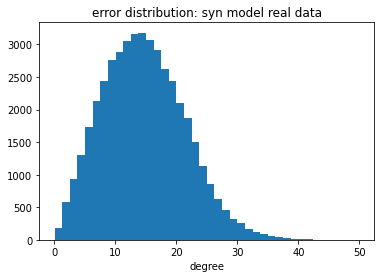

In [16]:
plt.hist(errors, bins=40)
plt.title("error distribution: syn model real data")
plt.xlabel("degree")

In [17]:
mean_error = errors.mean()
print(mean_error)

14.660605594369075


In [18]:
ix = 0
for k, v in images_errors.items():
    if ix >20:
        break
    print(k, v)
    ix += 1

p10/face/1064.jpg 49.95993790441597
p02/face/1384.jpg 48.157252171484
p10/face/2584.jpg 46.8934420773529
p05/face/1764.jpg 43.044729570140994
p14/face/1051.jpg 42.77265594608241
p14/face/761.jpg 42.2928476603808
p14/face/1021.jpg 41.861920605730106
p06/face/947.jpg 41.690438330259376
p08/face/1617.jpg 41.44541005912725
p14/face/252.jpg 41.25945392403653
p06/face/957.jpg 41.22029961962576
p10/face/1478.jpg 41.18101972395625
p12/face/493.jpg 41.11558834940966
p06/face/380.jpg 41.1041057673431
p06/face/665.jpg 41.01282182906449
p12/face/534.jpg 40.84604253446143
p14/face/398.jpg 40.5060068345106
p14/face/1467.jpg 40.48195193873705
p14/face/1215.jpg 40.19778594386257
p06/face/112.jpg 40.196617718739645
p14/face/1023.jpg 39.84434359451673


In [19]:
len(images_errors)

45000

In [20]:
ix = 0
for k, v in images_errors.items():
    if ix >20:
        break
    print(k, v)
    ix += 1

p10/face/1064.jpg 49.95993790441597
p02/face/1384.jpg 48.157252171484
p10/face/2584.jpg 46.8934420773529
p05/face/1764.jpg 43.044729570140994
p14/face/1051.jpg 42.77265594608241
p14/face/761.jpg 42.2928476603808
p14/face/1021.jpg 41.861920605730106
p06/face/947.jpg 41.690438330259376
p08/face/1617.jpg 41.44541005912725
p14/face/252.jpg 41.25945392403653
p06/face/957.jpg 41.22029961962576
p10/face/1478.jpg 41.18101972395625
p12/face/493.jpg 41.11558834940966
p06/face/380.jpg 41.1041057673431
p06/face/665.jpg 41.01282182906449
p12/face/534.jpg 40.84604253446143
p14/face/398.jpg 40.5060068345106
p14/face/1467.jpg 40.48195193873705
p14/face/1215.jpg 40.19778594386257
p06/face/112.jpg 40.196617718739645
p14/face/1023.jpg 39.84434359451673


In [21]:
ix = 0
for k, v in images_errors.items():
    ix += 1
    if ix <44980:
        continue
    print(k, v)
    

p14/face/238.jpg 0.3884347907803918
p11/face/95.jpg 0.35737316322277235
p08/face/2036.jpg 0.3456420306336041
p09/face/2222.jpg 0.3386396241643315
p06/face/749.jpg 0.308652482039855
p09/face/1322.jpg 0.30831588493241535
p00/face/1687.jpg 0.30791675745106795
p13/face/763.jpg 0.2937963934672409
p04/face/105.jpg 0.2919145751738629
p11/face/2546.jpg 0.2879034805986369
p00/face/1498.jpg 0.2878471173599586
p11/face/2720.jpg 0.28082782893200825
p08/face/1706.jpg 0.2616561521214867
p01/face/2499.jpg 0.188201085963494
p09/face/571.jpg 0.17787971454010898
p05/face/1497.jpg 0.15635358751336093
p09/face/1623.jpg 0.15570588264591437
p03/face/1843.jpg 0.11845313584146638
p02/face/178.jpg 0.08071584178115902
p13/face/1291.jpg 0.0750567220269789
p04/face/945.jpg 0.03199657174891934


In [22]:
ix = 0
for k, v in images_errors.items():
    ix += 1
    if ix <22480 or ix >22500:
        continue
    print(k, v)

p07/face/2403.jpg 14.295408161720603
p11/face/2393.jpg 14.295255458495816
p14/face/764.jpg 14.29499370438443
p00/face/2486.jpg 14.29449243952885
p12/face/2086.jpg 14.29437624097635
p06/face/740.jpg 14.294375611948508
p11/face/1567.jpg 14.29436846295525
p06/face/992.jpg 14.293851485315091
p05/face/2216.jpg 14.293712925089634
p12/face/1558.jpg 14.29367103857881
p03/face/973.jpg 14.293452126192403
p07/face/881.jpg 14.293191301415717
p06/face/2872.jpg 14.292567528827089
p02/face/1865.jpg 14.292237452102388
p06/face/82.jpg 14.291974075448627
p01/face/1512.jpg 14.291141476785437
p13/face/1731.jpg 14.291125422025544
p13/face/2773.jpg 14.291034174930333
p05/face/1240.jpg 14.29011159076981
p01/face/2039.jpg 14.289443660533104
p12/face/28.jpg 14.289237261181162
